# Meta-Training SNNs using MAML

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

from yingyang.dataset import YinYangDataset

import random
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import argparse

In [2]:
%load_ext autoreload
%autoreload 2

## Data and Config

In [3]:
from eventprop.config import get_flat_dict_from_nested

In [4]:
data_config = {
    "seed": 42,
    "dataset": "ying_yang",
    "deterministic": True,
    "batch_size": 16,
    "encoding": "latency",
    "T": 50,
    "dt": 1e-3,
    "t_min": 2,
    "data_folder": "../../../data/",
    "n_samples_per_task": 100,
}
data_args = argparse.Namespace(**data_config)

In [5]:
torch.manual_seed(data_config["seed"])
np.random.seed(data_config["seed"])
random.seed(data_config["seed"])

data_config["dataset"] = data_config["dataset"]
if data_config["deterministic"]:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Rotation Ying Yang data for Meta Learning

In [6]:
n_metadata = 45

train_rotations = np.linspace(0, np.pi / 2, n_metadata, endpoint=False)
test_rotations = np.linspace(np.pi / 2, np.pi, n_metadata, endpoint=False)
val_rotations = np.linspace(np.pi, 3 * np.pi / 2, n_metadata, endpoint=False)

train_seeds = np.arange(0, 2 * n_metadata, 2)
test_seeds = np.arange(2 * n_metadata, 4 * n_metadata, 2)
val_seeds = np.arange(4 * n_metadata, 6 * n_metadata, 2)

rotations = {"train": train_rotations, "test": test_rotations, "val": val_rotations}

seeds = {"train": train_seeds, "test": test_seeds, "val": val_seeds}

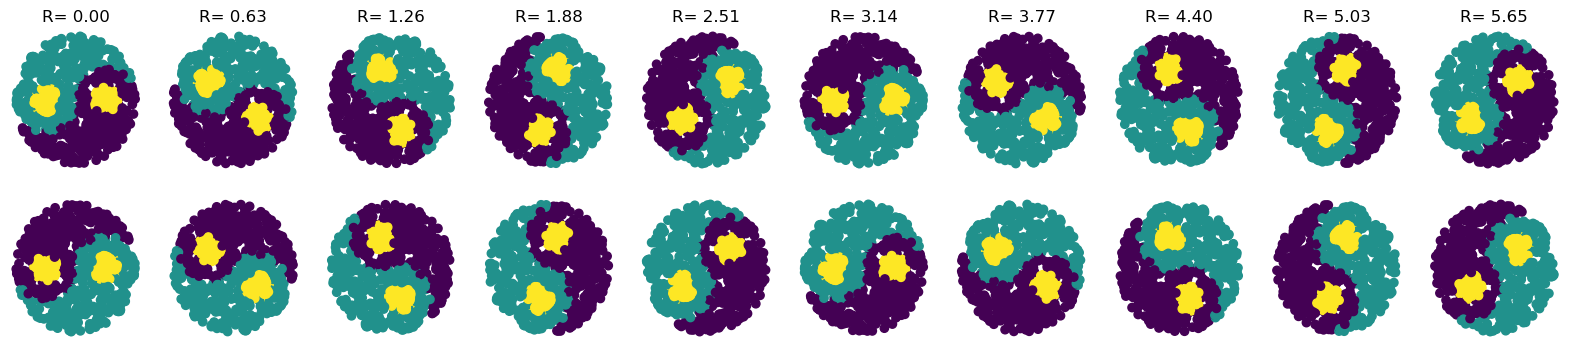

In [7]:
plot_rotations = np.linspace(0, 2 * np.pi, 10, endpoint=False)
fig, axs = plt.subplots(
    2,
    len(plot_rotations),
    figsize=(2 * len(plot_rotations), 4),
    sharex=True,
    sharey=True,
)
for r_axs, r in zip(axs.T, plot_rotations):
    train_dataset = YinYangDataset(size=1000, seed=data_config["seed"], rotation=r)
    for i, ax in enumerate(r_axs):
        data = train_dataset.data[:, 2 * i : 2 * i + 2]
        ax.scatter(data[:, 0], data[:, 1], c=train_dataset.targets)
        ax.axis("off")
        ax.grid(True)
        # ax.set_title(f"Min Max = {data.min():.2f} {data.max():.2f}")
        if i == 0:
            ax.set_title(f"R= {r:.2f}")

In [8]:
from torchmeta.utils.data import BatchMetaDataLoader
from torchmeta.utils.data import ClassDataset, CombinationMetaDataset
from torchvision.transforms import Compose
from torch.utils.data import ConcatDataset
from torchmeta.transforms import ClassSplitter
from eventprop.training import encode_data

In [9]:
class YinYangClassDataset(ClassDataset):
    def __init__(
        self,
        meta_train=False,
        meta_val=False,
        meta_test=False,
        meta_split=None,
        transform=None,
        target_transform=None,
    ):

        if meta_train:
            split_name = "train"
        if meta_val:
            split_name = "val"
        if meta_test:
            split_name = "test"
        self.split_name = split_name

        self.transform = transform
        self.target_transform = target_transform

        super().__init__(
            meta_train=meta_train,
            meta_val=meta_val,
            meta_test=meta_test,
            meta_split=meta_split,
        )

        self._labels = np.arange(len(rotations[split_name]))
        self._num_classes = len(rotations[split_name])
        self.loaded_datasets = {}

    @property
    def labels(self):
        return self._labels

    @property
    def num_classes(self):
        return self._num_classes

    def __getitem__(self, index):
        rotation = rotations[self.split_name][index]
        seed = seeds[self.split_name][index]

        if rotation not in self.loaded_datasets:
            trainset = YinYangDataset(
                size=data_config["n_samples_per_task"],
                seed=seed,
                rotation=rotation,
                transform=self.transform,
            )
            testset = YinYangDataset(
                size=data_config["n_samples_per_task"],
                seed=seed + 1,
                rotation=rotation,
                transform=self.transform,
            )
            self.loaded_datasets[rotation] = ConcatDataset([trainset, testset])
            if self.transform is not None:
                self.loaded_datasets[rotation].transform = self.transform
            self.loaded_datasets[rotation].index = index
            self.loaded_datasets[rotation].target_transform_append = lambda x: None

        return self.loaded_datasets[rotation]

In [10]:
class YingYangMetaDataset(CombinationMetaDataset):
    def __init__(
        self,
        num_classes_per_task=None,
        meta_train=False,
        meta_val=False,
        meta_test=False,
        meta_split=None,
        transform=None,
    ):
        dataset = YinYangClassDataset(
            meta_train=meta_train,
            meta_val=meta_val,
            meta_test=meta_test,
            meta_split=meta_split,
            transform=transform,
        )
        super().__init__(
            dataset,
            num_classes_per_task=num_classes_per_task,
        )

In [11]:
encode_tranform = lambda s: (encode_data(s[0], data_args), s[1])
meta_train_dataset = YingYangMetaDataset(
    num_classes_per_task=1, meta_train=True, transform=encode_tranform
)
meta_val_dataset = YingYangMetaDataset(
    num_classes_per_task=1, meta_val=True, transform=encode_tranform
)
meta_test_dataset = YingYangMetaDataset(
    num_classes_per_task=1, meta_test=True, transform=encode_tranform
)

In [12]:
meta_train_dataset, meta_val_dataset, meta_test_dataset = [
    ClassSplitter(
        d,
        num_train_per_class=data_config["n_samples_per_task"],
        num_test_per_class=data_config["n_samples_per_task"],
        shuffle=False,
    )
    for d in [meta_train_dataset, meta_val_dataset, meta_test_dataset]
]

In [13]:
meta_train_dataset[{0}]["train"][0][0].shape

torch.Size([50, 1, 5])

In [14]:
meta_train_dataloader = BatchMetaDataLoader(
    meta_train_dataset,
    data_config["batch_size"],
    shuffle=True,
    num_workers=0,
)
meta_val_dataloader = BatchMetaDataLoader(
    meta_val_dataset,
    data_config["batch_size"],
    shuffle=False,
    num_workers=0,
)
meta_test_dataloader = BatchMetaDataLoader(
    meta_test_dataset,
    data_config["batch_size"],
    shuffle=False,
    num_workers=0,
)

In [15]:
batch = next(iter(meta_train_dataloader))

## Models

In [16]:
from eventprop.models import Meta_SNN, SpikeCELoss
import torch.nn as nn

In [17]:
model_config = {
    "model_type": "eventprop",
    "snn": {
        "T": data_config["T"],
        "dt": data_config["dt"],
        "tau_m": 20e-3,
        "tau_s": 5e-3,
    },
    "weights": {
        "init_mode": "kaiming_both",
        "scale_0_mu": 3,
        "scale_0_sigma": 1.5,
        "scale_1_mu": 5,
        "scale_1_sigma": 2.5,
        "n_hid": 120,
        "resolve_silent": False,
        "dropout": 0.0,
    },
    "device": (
        torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    ),
}

n_ins = {"mnist": 784, "ying_yang": 5 if data_config["encoding"] == "latency" else 4}
n_outs = {"mnist": 10, "ying_yang": 3}

In [18]:
training_config = {
    "n_epochs": 60,
    "loss": "ce_temporal",
    "alpha": 3e-3,
    "xi": 0.5,
    "beta": 6.4,
    "n_tests": 3,
    "exclude_equal": False,
}

## Inner Loop Optim
optim_config = {
    "lr": 5e-3,
    "weight_decay": 0.0,
    "optimizer": "adam",
    "gamma": 0.95,
}

maml_config = {
    "num_shots": 100,
    "num_shots_test": 1000,
    "first_order": True,
    "meta-lr": 1e-3,
    "inner-lr": 1.0,
    "learn_step_size": False,
}

default_config = {
    "data": data_config,
    "model": model_config,
    "training": training_config,
    "optim": optim_config,
}
config = get_flat_dict_from_nested(default_config)

In [19]:
dims = [n_ins[config["dataset"]]]
if config["n_hid"] is not None and isinstance(config["n_hid"], list):
    dims.extend(config["n_hid"])
elif isinstance(config["n_hid"], int):
    dims.append(config["n_hid"])
dims.append(n_outs[config["dataset"]])

model = Meta_SNN(dims, **config).to(config["device"])

In [20]:
from snn_maml.maml import ModelAgnosticMetaLearning

In [21]:
meta_optimizer = torch.optim.Adam(model.parameters(), lr=maml_config["meta-lr"])
metalearner = ModelAgnosticMetaLearning(
    model,
    meta_optimizer,
    step_size=maml_config["inner-lr"],
    first_order=maml_config["first_order"],
    loss_function=SpikeCELoss(xi=config["xi"]),
)

In [22]:
batch["train"][0].shape

torch.Size([16, 100, 50, 1, 5])

In [23]:
metalearner.get_outer_loss(batch, stream_mode=True)

grad is None for layers.0.weight
grad is None for layers.1.weight
grad is None for layers.0.weight
grad is None for layers.1.weight
grad is None for layers.0.weight
grad is None for layers.1.weight
grad is None for layers.0.weight
grad is None for layers.1.weight
grad is None for layers.0.weight
grad is None for layers.1.weight
grad is None for layers.0.weight
grad is None for layers.1.weight
grad is None for layers.0.weight
grad is None for layers.1.weight
grad is None for layers.0.weight
grad is None for layers.1.weight
grad is None for layers.0.weight
grad is None for layers.1.weight
grad is None for layers.0.weight
grad is None for layers.1.weight
grad is None for layers.0.weight
grad is None for layers.1.weight
grad is None for layers.0.weight
grad is None for layers.1.weight
grad is None for layers.0.weight
grad is None for layers.1.weight
grad is None for layers.0.weight
grad is None for layers.1.weight
grad is None for layers.0.weight
grad is None for layers.1.weight
grad is No

(tensor(1.0986, grad_fn=<DivBackward0>),
 {'num_tasks': 16,
  'inner_losses': array([[1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123,
          1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123,
          1.0986123, 1.0986123, 1.0986123, 1.0986123]], dtype=float32),
  'outer_losses': array([1.098612, 1.098612, 1.098612, 1.098612, 1.098612, 1.098612,
         1.098612, 1.098612, 1.098612, 1.098612, 1.098612, 1.098612,
         1.098612, 1.098612, 1.098612, 1.098612], dtype=float32),
  'mean_outer_loss': 1.0986119508743286,
  'accuracies_before': array([0.28, 0.36, 0.28, 0.43, 0.33, 0.32, 0.32, 0.32, 0.29, 0.34, 0.31,
         0.3 , 0.28, 0.29, 0.36, 0.43], dtype=float32),
  'accuracies_after': array([0.39, 0.36, 0.36, 0.3 , 0.32, 0.47, 0.3 , 0.29, 0.29, 0.28, 0.34,
         0.35, 0.39, 0.29, 0.3 , 0.3 ], dtype=float32)})